# Step 1: Feature Extraction 

In [8]:
import os
import cv2
import numpy as np

# Function to extract 24-dimensional color histogram features from a single patch
def extract_patch_histogram(patch, bins=(8, 8, 8)):
    # Extract 8-bin color histograms for R, G, B channels
    hist_r = cv2.calcHist([patch], [0], None, [bins[0]], [0, 256]).flatten()  # Red channel
    hist_g = cv2.calcHist([patch], [1], None, [bins[1]], [0, 256]).flatten()  # Green channel
    hist_b = cv2.calcHist([patch], [2], None, [bins[2]], [0, 256]).flatten()  # Blue channel
    
    # Normalize histograms
    hist_r /= np.sum(hist_r)
    hist_g /= np.sum(hist_g)
    hist_b /= np.sum(hist_b)
    
    # Concatenate R, G, B histograms into a 24-dimensional vector
    feature_vector = np.concatenate([hist_r, hist_g, hist_b])
    return feature_vector

# Function to divide image into 32x32 patches and extract features from each patch
def extract_image_features(image, patch_size=(32, 32), bins=(8, 8, 8)):
    img_h, img_w, _ = image.shape
    all_patches_features = []
    
    # Extract patches
    for i in range(0, img_h, patch_size[0]):
        for j in range(0, img_w, patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]]
            if patch.shape[0] == patch_size[0] and patch.shape[1] == patch_size[1]:
                patch_features = extract_patch_histogram(patch, bins)
                all_patches_features.append(patch_features)
    
    return np.array(all_patches_features)

# Function to save feature vectors to a file
def save_feature_vectors(feature_vectors, save_path):
    np.save(save_path, feature_vectors)

# Process the images in the 'botanical_garden', 'bus_interior', and 'elevator_shaft' classes for both training and test datasets
def process_images_from_folder(folder_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for class_folder in os.listdir(folder_path):
        class_folder_path = os.path.join(folder_path, class_folder)
        output_class_folder = os.path.join(output_folder, class_folder)
        if not os.path.exists(output_class_folder):
            os.makedirs(output_class_folder)
        
        for image_name in os.listdir(class_folder_path):
            image_path = os.path.join(class_folder_path, image_name)
            image = cv2.imread(image_path)
            if image is not None:
                features = extract_image_features(image)
                save_path = os.path.join(output_class_folder, f"{image_name.split('.')[0]}_features.npy")
                save_feature_vectors(features, save_path)
                print(f"Processed and saved features for {image_name}")

# Example usage for processing train and test datasets
train_folder = r'/home/user/Desktop/SPR_assignment02.o/SPR_assignment02/SPR_Assign02/group03/3class_scene_image_dataset/train'  # Path to the train dataset
test_folder = r'/home/user/Desktop/SPR_assignment02.o/SPR_assignment02/SPR_Assign02/group03/3class_scene_image_dataset/test'    # Path to the test dataset
output_train_features = r'/home/user/Desktop/SPR_assignment02.o/SPR_assignment02/SPR_Assign02/group03/3class_scene_image_dataset/output_train_features'  # Folder to save train features
output_test_features = r'/home/user/Desktop/SPR_assignment02.o/SPR_assignment02/SPR_Assign02/group03/3class_scene_image_dataset/output_test_features'    # Folder to save test features

# Process training set
print("Processing training images...")
process_images_from_folder(train_folder, output_train_features)

# Process test set
print("Processing test images...")
process_images_from_folder(test_folder, output_test_features)

Processing training images...
Processed and saved features for sun_bejituvblxjrssxl.jpg
Processed and saved features for sun_ajcnfezfvmclnyac.jpg
Processed and saved features for sun_aafvyefdfobptgrz.jpg
Processed and saved features for sun_beroqgzewiqbdocz.jpg
Processed and saved features for sun_asvnyjcbsipjnsre.jpg
Processed and saved features for sun_axvdfabagcfcrjdn.jpg
Processed and saved features for sun_apinwducjegkiqxk.jpg
Processed and saved features for sun_agejojvttluyffmk.jpg
Processed and saved features for sun_auyjcmqmsxiatjtg.jpg
Processed and saved features for sun_ajswveykgvwddpqd.jpg
Processed and saved features for sun_afxxlyvgmhxzkxjs.jpg
Processed and saved features for sun_aykzcanmbpokcood.jpg
Processed and saved features for sun_aabpsmafrtneeadl.jpg
Processed and saved features for sun_afcagahirnkxvaja.jpg
Processed and saved features for sun_ayqetykpphjpuabg.jpg
Processed and saved features for sun_abgifrznoippetrg.jpg
Processed and saved features for sun_albvr

# Step 2: Clustering Algo. on Training Dataset 

In [2]:
import os
import numpy as np

# K-means implementation for initializing GMM (with means and covariance matrices)
def initialize_centroids(X, k):
    indices = np.random.choice(len(X), k, replace=False)
    return X[indices]

def assign_clusters(X, centroids):
    clusters = []
    for x in X:
        distances = [np.linalg.norm(x - centroid) for centroid in centroids]
        clusters.append(np.argmin(distances))
    return np.array(clusters)

def update_centroids(X, clusters, k):
    new_centroids = []
    for i in range(k):
        cluster_points = X[clusters == i]
        if len(cluster_points) > 0:
            new_centroids.append(np.mean(cluster_points, axis=0))
        else:
            new_centroids.append(np.random.rand(X.shape[1]))  # Reinitialize if cluster is empty
    return np.array(new_centroids)

# Calculate covariance matrices for each cluster
def calculate_covariances(X, clusters, means, k):
    covariances = []
    for i in range(k):
        cluster_points = X[clusters == i]
        if len(cluster_points) > 1:
            covariance = np.cov(cluster_points.T)
        else:
            covariance = np.eye(X.shape[1])  # Identity matrix for empty or single-point clusters
        covariances.append(covariance + np.eye(X.shape[1]) * 1e-6)  # Regularize to avoid singularity
    return covariances

def kmeans(X, k, max_iters=100):
    centroids = initialize_centroids(X, k)
    for _ in range(max_iters):
        clusters = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, clusters, k)
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    
    covariances = calculate_covariances(X, clusters, centroids, k)
    return centroids, covariances, clusters

# Perform K-means clustering on each class separately
def perform_clustering_class_by_class(train_features_path, num_clusters):
    class_folders = ['botanical_garden', 'bus_interior', 'elevator_shaft']
    kmeans_params = {}
    
    for class_name in class_folders:
        print(f"\nPerforming K-means clustering for class: {class_name}")
        
        class_folder = os.path.join(train_features_path, class_name)
        class_features = np.vstack([np.mean(np.load(os.path.join(class_folder, f)), axis=0) for f in os.listdir(class_folder)])
        
        # Perform K-means clustering on each class
        centroids, covariances, clusters = kmeans(class_features, num_clusters)
        
        # Store the parameters for this class (means, covariances)
        kmeans_params[class_name] = (centroids, covariances)
        
        # Print K-means parameters for the class
        print(f"K-means parameters for class {class_name}:")
        print("Centroids (means):")
        for i, centroid in enumerate(centroids):
            print(f"Cluster {i + 1} centroid:\n{centroid}")
        
        print("\nCovariance Matrices:")
        for i, covariance in enumerate(covariances):
            print(f"Cluster {i + 1} covariance matrix:\n{covariance}")
    
    return kmeans_params

# Example usage
train_features_path = r'/home/user/Desktop/SPR_assignment02.o/SPR_assignment02/SPR_Assign02/group03/3class_scene_image_dataset/output_train_features'
num_clusters = 1  # Number of clusters
kmeans_params = perform_clustering_class_by_class(train_features_path, num_clusters)


Performing K-means clustering for class: botanical_garden
K-means parameters for class botanical_garden:
Centroids (means):
Cluster 1 centroid:
[0.2478319  0.24385756 0.17945892 0.10674162 0.05937319 0.03904473
 0.04312417 0.08056786 0.08767479 0.16808455 0.19478346 0.17745312
 0.13724852 0.09712025 0.06233314 0.07530224 0.09952146 0.19124779
 0.19333957 0.16990194 0.1297126  0.08736759 0.06008637 0.06882266]

Covariance Matrices:
Cluster 1 covariance matrix:
[[ 2.43623073e-02 -2.19279667e-03 -8.29256473e-03 -6.31572531e-03
  -4.20091550e-03 -1.64465715e-03 -4.17495595e-04 -1.29715171e-03
   7.83417863e-03  6.69963360e-03 -1.22151100e-03 -4.00299932e-03
  -5.38970238e-03 -2.66939673e-03  2.46074436e-04 -1.49627754e-03
   6.98451861e-03  3.24603334e-03 -1.73458296e-03 -2.79331309e-03
  -2.58375042e-03 -7.35291556e-04 -8.86639164e-04 -1.49697444e-03]
 [-2.19279667e-03  7.89591936e-03  1.90479928e-03 -1.42436517e-03
  -1.68932610e-03 -1.11201348e-03 -1.41383742e-03 -1.96738010e-03
  -2.1

# Step 3: Building the Bayes Classifier Using GMM


Training GMM for class: botanical_garden

Final GMM Parameters for class botanical_garden:
Means (Centroids): [[0.2478319  0.24385759 0.17945893 0.10674163 0.05937319 0.03904474
  0.04312416 0.08056786 0.0876748  0.16808451 0.19478345 0.17745311
  0.1372485  0.09712025 0.06233314 0.07530223 0.09952146 0.19124778
  0.19333957 0.16990194 0.12971261 0.08736759 0.06008638 0.06882267]]
Covariances: [array([[ 2.38750812e-02, -2.14894074e-03, -8.12671344e-03,
        -6.18941080e-03, -4.11689719e-03, -1.61176401e-03,
        -4.09145683e-04, -1.27120867e-03,  7.67749506e-03,
         6.56564093e-03, -1.19708078e-03, -3.92293933e-03,
        -5.28190834e-03, -2.61600880e-03,  2.41152947e-04,
        -1.46635199e-03,  6.84482824e-03,  3.18111268e-03,
        -1.69989130e-03, -2.73744682e-03, -2.53207541e-03,
        -7.20585725e-04, -8.68906380e-04, -1.46703496e-03],
       [-2.14894074e-03,  7.73802097e-03,  1.86670330e-03,
        -1.39587787e-03, -1.65553958e-03, -1.08977321e-03,
        -1

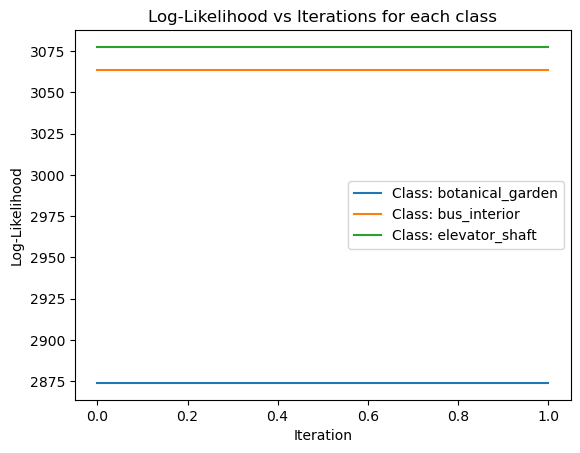

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# GMM implementation using K-means initialization
def gaussian_pdf(x, mean, cov):
    n = len(x)
    cov_det = np.linalg.det(cov)
    if cov_det <= 0:
        cov_det = 1e-6  # Handle singular matrix case
    cov_inv = np.linalg.inv(cov + np.eye(len(cov)) * 1e-6)
    diff = x - mean
    exponent = -0.5 * np.dot(diff.T, np.dot(cov_inv, diff))
    return np.exp(exponent) / np.sqrt((2 * np.pi)**n * cov_det)

def expectation_step(X, means, covariances, weights):
    n, k = X.shape[0], len(means)
    responsibilities = np.zeros((n, k))
    for i in range(k):
        for j in range(n):
            responsibilities[j, i] = weights[i] * gaussian_pdf(X[j], means[i], covariances[i])
    responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
    responsibilities_sum[responsibilities_sum == 0] = 1e-6  # Avoid divide by zero
    responsibilities /= responsibilities_sum
    return responsibilities

def maximization_step(X, responsibilities):
    n, d = X.shape
    k = responsibilities.shape[1]
    weights = responsibilities.sum(axis=0) / n
    means = np.dot(responsibilities.T, X) / responsibilities.sum(axis=0)[:, None]
    covariances = []
    for i in range(k):
        diff = X - means[i]
        covariances.append(np.dot((responsibilities[:, i] * diff.T), diff) / responsibilities[:, i].sum())
        covariances[i] += np.eye(d) * 1e-6  # Regularize covariance
    return means, covariances, weights

def gmm_em(X, k, means_init, covariances_init, max_iters=100, tol=1e-6):
    means = means_init
    covariances = covariances_init
    weights = np.ones(k) / k  # Initialize weights uniformly
    
    log_likelihoods = []
    
    for iteration in range(max_iters):
        responsibilities = expectation_step(X, means, covariances, weights)
        means, covariances, weights = maximization_step(X, responsibilities)
        
        log_likelihood = np.sum([
            np.log(np.maximum(np.sum([weights[i] * gaussian_pdf(X[j], means[i], covariances[i]) for i in range(k)]), 1e-6))
            for j in range(len(X))
        ])
        log_likelihoods.append(log_likelihood)
        
        if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
    
    return means, covariances, weights, log_likelihoods

# Train GMM on each class using K-means initialization and print parameters for each class
def train_gmm_class_by_class(train_features_path, kmeans_params, num_clusters):
    class_folders = ['botanical_garden', 'bus_interior', 'elevator_shaft']
    gmm_models = {}
    log_likelihoods_per_class = {}
    
    for class_name in class_folders:
        print(f"\nTraining GMM for class: {class_name}")
        
        # Load the class features
        class_folder = os.path.join(train_features_path, class_name)
        class_features = np.vstack([np.mean(np.load(os.path.join(class_folder, f)), axis=0) for f in os.listdir(class_folder)])
        
        # Get K-means initialization parameters for this class
        centroids, covariances = kmeans_params[class_name]
        
        # Train GMM using the EM algorithm with K-means initialization
        means, covariances, weights, log_likelihoods = gmm_em(class_features, num_clusters, centroids, covariances)
        
        # Store GMM parameters for this class
        gmm_models[class_name] = (means, covariances, weights)
        log_likelihoods_per_class[class_name] = log_likelihoods
        
        # Print final GMM parameters for the class
        print(f"\nFinal GMM Parameters for class {class_name}:")
        print("Means (Centroids):", means)
        print("Covariances:", covariances)
        print("Mixing Coefficients (Weights):", weights)
        
        # Plot log-likelihood vs iterations for the class
        plt.plot(log_likelihoods, label=f'Class: {class_name}')
    
    # Show the log-likelihood plot for all classes
    plt.title('Log-Likelihood vs Iterations for each class')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.legend()
    plt.show()
    
    return gmm_models

# Example usage
train_features_path = r'/home/user/Desktop/SPR_assignment02.o/SPR_assignment02/SPR_Assign02/group03/3class_scene_image_dataset/output_train_features'
gmm_models = train_gmm_class_by_class(train_features_path, kmeans_params, num_clusters)

# Step 4: Test Classifier on Test Dataset and printing Performance Metric

In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Classify new data points using trained GMM
def classify_gmm(x, gmm_models):
    likelihoods = {}
    for class_name, (means, covariances, weights) in gmm_models.items():
        likelihoods[class_name] = np.sum([weights[i] * gaussian_pdf(x, means[i], covariances[i]) for i in range(len(means))])
    return max(likelihoods, key=likelihoods.get)

def evaluate_gmm(test_features_path, gmm_models):
    label_dict = {'botanical_garden': 0, 'bus_interior': 1, 'elevator_shaft': 2}
    
    y_true = []
    y_pred = []
    
    for class_name in label_dict:
        class_label = label_dict[class_name]
        class_folder = os.path.join(test_features_path, class_name)
        test_features = np.vstack([np.mean(np.load(os.path.join(class_folder, f)), axis=0) for f in os.listdir(class_folder)])
        
        for feature in test_features:
            predicted_class = classify_gmm(feature, gmm_models)
            y_true.append(class_label)
            y_pred.append(label_dict[predicted_class])
    
    return np.array(y_true), np.array(y_pred)

def calculate_metrics(y_true, y_pred):
    label_names = ['botanical_garden', 'bus_interior', 'elevator_shaft']
    precision_per_class = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    
    mean_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    mean_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    mean_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    accuracy = np.mean(y_true == y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    print("\nClass-wise Precision, Recall, F1-score:")
    for i, class_name in enumerate(label_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision_per_class[i]:.4f}")
        print(f"  Recall: {recall_per_class[i]:.4f}")
        print(f"  F1-Score: {f1_per_class[i]:.4f}")
    
    print("\nMean Precision, Recall, F1-Score (weighted):")
    print(f"  Mean Precision: {mean_precision:.4f}")
    print(f"  Mean Recall: {mean_recall:.4f}")
    print(f"  Mean F1-Score: {mean_f1:.4f}")

# Example usage
test_features_path = r'/home/user/Desktop/SPR_assignment02.o/SPR_assignment02/SPR_Assign02/group03/3class_scene_image_dataset/output_test_features'
y_true, y_pred = evaluate_gmm(test_features_path, gmm_models)
calculate_metrics(y_true, y_pred)

Accuracy: 62.00%
Confusion Matrix:
[[36  8  6]
 [ 6 29 15]
 [ 9 13 28]]

Class-wise Precision, Recall, F1-score:
botanical_garden:
  Precision: 0.7059
  Recall: 0.7200
  F1-Score: 0.7129
bus_interior:
  Precision: 0.5800
  Recall: 0.5800
  F1-Score: 0.5800
elevator_shaft:
  Precision: 0.5714
  Recall: 0.5600
  F1-Score: 0.5657

Mean Precision, Recall, F1-Score (weighted):
  Mean Precision: 0.6191
  Mean Recall: 0.6200
  Mean F1-Score: 0.6195
